In [1]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 11.1 그레디언트 소실과 폭주 문제

In [2]:
def logit(z):
    return 1 / (1 + np.exp(-z))

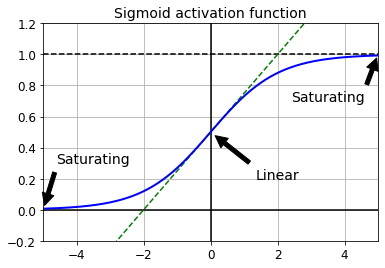

In [3]:
z = np.linspace(-5,5,200)

plt.plot([-5,5],[0,0],'k-')
plt.plot([-5,5],[1,1],'k--')
plt.plot([0,0],[-0.2,1.2],'k-')
plt.plot([-5,5],[-3/4,7/4],'g--')
plt.plot(z, logit(z), "b-", linewidth=2)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Saturating', xytext=(3.5, 0.7), xy=(5, 1), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Saturating', xytext=(-3.5, 0.3), xy=(-5, 0), arrowprops=props, fontsize=14, ha="center")
plt.annotate('Linear', xytext=(2, 0.2), xy=(0, 0.5), arrowprops=props, fontsize=14, ha="center")
plt.grid(True)
plt.title("Sigmoid activation function", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

plt.show()

### 11.1.1 글로럿과 He 초기화

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [5]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                         distribution='uniform')
keras.layers.Dense(10, activation="sigmoid", kernel_initializer=init)

### 11.1.2 수렴하지 않는 활성화 함수
LeakyReLU

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z,z)

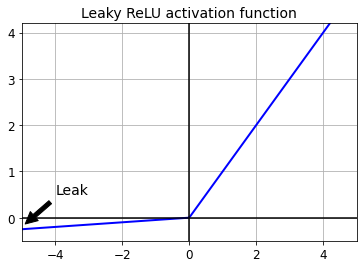

In [8]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

plt.show()

In [9]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [10]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

LeakyReLU를 이용해 MNIST에서 신경망을 훈련

In [11]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [13]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [14]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7900
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8064
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8200
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

PReLU 테스트

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [16]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [17]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.8197 - accuracy: 0.7355 - val_loss: 0.7305 - val_accuracy: 0.7628
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7882
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.6331 - accuracy: 0.7910 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5917 - accuracy: 0.8057 - val_loss: 0.5656 - val_accuracy: 0.8180
Epoch 6/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5618 - accuracy: 0.8134 - val_loss: 0.5406 - val_accuracy: 0.8240
Epoch 7/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

ELU (Exponential Linear Unit)

In [18]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

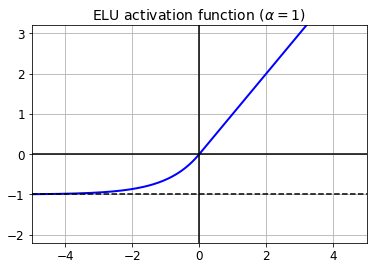

In [19]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [20]:
keras.layers.Dense(10, activation="elu")

SELU

In [21]:
from scipy.special import erfc

# alpha와 scale은 평균 0과 표준 편차 1로 자기 정규화합니다
# (논문에 있는 식 14 참조):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [22]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

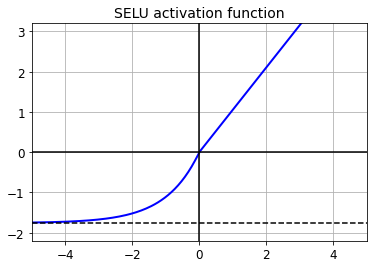

In [23]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

plt.show()

In [24]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # 표준화된 입력
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun 초기화
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


In [25]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

In [26]:
np.random.seed(42)
tf.random.set_seed(42)

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [29]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [30]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 41s 22ms/step - loss: 1.1462 - accuracy: 0.5713 - val_loss: 0.8621 - val_accuracy: 0.6730
Epoch 2/5
1719/1719 [==============================] - 37s 21ms/step - loss: 0.7794 - accuracy: 0.7203 - val_loss: 0.7310 - val_accuracy: 0.7390
Epoch 3/5
1719/1719 [==============================] - 38s 22ms/step - loss: 0.7385 - accuracy: 0.7260 - val_loss: 0.7697 - val_accuracy: 0.6972
Epoch 4/5
1719/1719 [==============================] - 36s 21ms/step - loss: 0.6333 - accuracy: 0.7567 - val_loss: 0.6109 - val_accuracy: 0.7776
Epoch 5/5
1719/1719 [==============================] - 37s 22ms/step - loss: 0.6537 - accuracy: 0.7617 - val_loss: 0.5789 - val_accuracy: 0.7930


### 11.1.3 배치 정규화
케라스로 배치 정규화 구현하기

In [31]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [32]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_111 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_112 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [33]:
# 첫 번째 배치 정규화 층의 파라미터
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [34]:
# 삭제될 예정
# bn1.updates

In [35]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [36]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.9021 - accuracy: 0.6946 - val_loss: 0.6012 - val_accuracy: 0.8004
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6103 - accuracy: 0.7904 - val_loss: 0.5175 - val_accuracy: 0.8240
Epoch 3/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5540 - accuracy: 0.8078 - val_loss: 0.4802 - val_accuracy: 0.8354
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5171 - accuracy: 0.8212 - val_loss: 0.4558 - val_accuracy: 0.8454
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4936 - accuracy: 0.8275 - val_loss: 0.4398 - val_accuracy: 0.8492
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4771 - accuracy: 0.8339 - val_loss: 0.4274 - val_accuracy: 0.8520
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4641 - accuracy: 0.8384 - val_loss: 0.4155 - val_accuracy:

In [37]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(100, kernel_initializer="he_normal", use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("elu"),
    keras.layers.Dense(10, activation="softmax")
])

In [38]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [39]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 8s 4ms/step - loss: 0.9111 - accuracy: 0.6995 - val_loss: 0.6415 - val_accuracy: 0.7860
Epoch 2/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6335 - accuracy: 0.7845 - val_loss: 0.5540 - val_accuracy: 0.8138
Epoch 3/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.5750 - accuracy: 0.8020 - val_loss: 0.5138 - val_accuracy: 0.8260
Epoch 4/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5379 - accuracy: 0.8151 - val_loss: 0.4887 - val_accuracy: 0.8346
Epoch 5/10
1719/1719 [==============================] - 9s 5ms/step - loss: 0.5135 - accuracy: 0.8222 - val_loss: 0.4712 - val_accuracy: 0.8416
Epoch 6/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4978 - accuracy: 0.8259 - val_loss: 0.4569 - val_accuracy: 0.8452
Epoch 7/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4853 - accuracy: 0.8331 - val_loss: 0.4454 - val_accuracy:

### 11.1.4 그레이디언트 클리핑
역전파될 때 일정 임곗값을 넘어서지 못하게 그레이디언트를 잘라내는 것

그레이디언트 벡터의 모든 원소를 -1.0과 1.0 사이로 클리핑합니다. 즉, 훈련되는 각 파라미터에 대한 손실의 모든 편미분 값을 -1.0에소 1.0으로 잘라냅니다.

In [40]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)
model.compile(loss="mse", optimizer=optimizer)

만약 그레이디언트 클리핑이 그레이디언트 벡털의 방향을 바꾸지 못하게 하려면 $clipnorm$을 지정하여 노름으로 클리핑해야 합니다.

In [41]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)
model.compile(loss="mse", optimizer=optimizer)

## 11.2 사전훈련된 층 재사용하기
전이학습 : 해결하려는 것과 비슷한 유형의 문제를 처리한 신경망이 이미 있는지 찾아본 다음, 그 신경망의 하위층을 재사용하는 것

### 11.2.1 케라스를 사용한 전이 학습 

In [42]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

* X_train_A : 샌달과 셔트(클래스5,6)을 제외한 모든 이미지
* X_train_B : 샌달과 셔츠 이미지 중 처음 200개만 가진 작은 훈련 세트

In [43]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [44]:
X_train_A.shape

(43986, 28, 28)

In [45]:
X_train_B.shape

(200, 28, 28)

In [46]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [47]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [48]:
tf.random.set_seed(42)
np.random.seed(42)

In [49]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [50]:
model_A.compile(loss="sparse_categorical_crossentropy",
               optimizer=keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

In [51]:
history = model_A.fit(X_train_A, y_train_A, epochs=20,
                     validation_data=(X_valid_A, y_valid_A))

Epoch 1/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3894 - val_accuracy: 0.8667
Epoch 2/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.3523 - accuracy: 0.8787 - val_loss: 0.3290 - val_accuracy: 0.8824
Epoch 3/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3013 - val_accuracy: 0.8999
Epoch 4/20
1375/1375 [==============================] - 4s 3ms/step - loss: 0.2973 - accuracy: 0.8974 - val_loss: 0.2892 - val_accuracy: 0.9018
Epoch 5/20
1375/1375 [==============================] - 5s 4ms/step - loss: 0.2834 - accuracy: 0.9020 - val_loss: 0.2772 - val_accuracy: 0.9061
Epoch 6/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2729 - accuracy: 0.9061 - val_loss: 0.2732 - val_accuracy: 0.9071
Epoch 7/20
1375/1375 [==============================] - 6s 4ms/step - loss: 0.2641 - accuracy: 0.9090 - val_loss: 0.2720 - val_accuracy:

In [52]:
model_A.save("my_model_A.h5")

In [53]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28,28]))
for n_hidden in (300,100,50,50,50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [54]:
model_B.compile(loss="binary_crossentropy",
               optimizer = keras.optimizers.SGD(learning_rate=1e-3),
               metrics=["accuracy"])

In [55]:
history = model_B.fit(X_train, y_train, epochs=20,
                     validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1005 - val_loss: nan - val_accuracy: 0.5000
Epoch 2/20
1719/1719 [==============================] - 6s 3ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.5000
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.5000
Epoch 4/20
1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.5000
Epoch 5/20
1719/1719 [==============================] - 6s 4ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.5000
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.5000
Epoch 7/20
1719/1719 [==============================] - 5s 3ms/step - loss: nan - accuracy: 0.1008 - val_loss: nan - val_accuracy: 0.5000
Epoch 8/20
1719/1719 [============

In [56]:
model_B.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_6 (Flatten)         (None, 784)               0         
                                                                 
 dense_123 (Dense)           (None, 300)               235500    
                                                                 
 dense_124 (Dense)           (None, 100)               30100     
                                                                 
 dense_125 (Dense)           (None, 50)                5050      
                                                                 
 dense_126 (Dense)           (None, 50)                2550      
                                                                 
 dense_127 (Dense)           (None, 50)                2550      
                                                                 
 dense_128 (Dense)           (None, 1)                

출력층만 제외하고 모든 층을 재사용

In [57]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

$model_A$ 와 $model_B_on_A$ 는 일부 층을 공유한다. 이를 원치 않는다면 $model_A$를 클론하면 된다.

In [58]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

model_B_on_A = keras.models.Sequential(model_A_clone.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

새로운 출력층이 랜덤하게 초기화되어 있으므로 큰 오차를 만들 것이다. 따라서 큰 오차 그레이디언트가 재사용된 가중치를 망칠 수 있다.\
이를 피하는 방법 중 하나는 처음 몇 번의 에포크 동안 재사용된 층을 동결하고 새로운 층에게 적절한 가중치를 학습할 시간을 주는 것이다.\
층을 동결하거나 동결을 해제한 후 반드시 모델을 컴파일 해야한다.

In [59]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [60]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-4),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 1s 40ms/step - loss: 0.2653 - accuracy: 0.9400 - val_loss: 0.2795 - val_accuracy: 0.9260
Epoch 2/4
7/7 [==============================] - 0s 18ms/step - loss: 0.2556 - accuracy: 0.9400 - val_loss: 0.2699 - val_accuracy: 0.9300
Epoch 3/4
7/7 [==============================] - 0s 17ms/step - loss: 0.2462 - accuracy: 0.9400 - val_loss: 0.2611 - val_accuracy: 0.9341
Epoch 4/4
7/7 [==============================] - 0s 18ms/step - loss: 0.2376 - accuracy: 0.9400 - val_loss: 0.2530 - val_accuracy: 0.9381
Epoch 1/16
7/7 [==============================] - 1s 41ms/step - loss: 0.2304 - accuracy: 0.9400 - val_loss: 0.2472 - val_accuracy: 0.9391
Epoch 2/16
7/7 [==============================] - 0s 19ms/step - loss: 0.2245 - accuracy: 0.9400 - val_loss: 0.2416 - val_accuracy: 0.9402
Epoch 3/16
7/7 [==============================] - 0s 19ms/step - loss: 0.2189 - accuracy: 0.9450 - val_loss: 0.2362 - val_accuracy: 0.9442
Epoch 4/16
7/7 [===============

In [61]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: nan - accuracy: 0.5000


[nan, 0.5]

In [62]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 3ms/step - loss: 0.1788 - accuracy: 0.9740


[0.17884398996829987, 0.9739999771118164]

## 11.3 고속 옵티마이저

### 11.3.1 모멘텀 최적화

In [63]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


### 11.3.2 네스테로프 가속 경사

In [64]:
optimizer = keras.optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)

### 11.3.3 AdaGrad

In [65]:
optimizer = keras.optimizers.Adagrad(lr=0.001)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\adagrad.py:74: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adagrad, self).__init__(name, **kwargs)


### 11.3.4 RMSProp

In [66]:
optimizer = keras.optimizers.RMSprop(lr=0.001, rho=0.9) #rho = 감쇠율

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\rmsprop.py:130: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(RMSprop, self).__init__(name, **kwargs)


### 11.3.5 Adam과 Nadam 최적화

In [67]:
optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [68]:
optimizer = keras.optimizers.Adamax(lr=0.001, beta_1=0.9, beta_2=0.999)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\adamax.py:90: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adamax, self).__init__(name, **kwargs)


In [69]:
optimizer = keras.optimizers.Nadam(lr=0.001, beta_1=0.9, beta_2=0.999)

C:\Users\user0216\anaconda3\envs\optml\lib\site-packages\keras\optimizer_v2\nadam.py:73: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Nadam, self).__init__(name, **kwargs)


### 11.3.6 학습률 스케줄링
- 거듭제곱 기반 스케쥴링 (power scheduling)

In [70]:
optimizer = keras.optimizers.SGD(lr=0.01, decay=1e-4)
# decay : 학습률을 나누기 위해 수행할 스템 수

In [71]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [72]:
n_epochs=25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4898 - accuracy: 0.8265 - val_loss: 0.4063 - val_accuracy: 0.8610
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3793 - accuracy: 0.8651 - val_loss: 0.3731 - val_accuracy: 0.8722
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3467 - accuracy: 0.8777 - val_loss: 0.3746 - val_accuracy: 0.8726
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3258 - accuracy: 0.8845 - val_loss: 0.3511 - val_accuracy: 0.8786
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3107 - accuracy: 0.8896 - val_loss: 0.3447 - val_accuracy: 0.8784
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2972 - accuracy: 0.8939 - val_loss: 0.3417 - val_accuracy: 0.8834
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2871 - accuracy: 0.8980 - val_loss: 0.3379 - val_accuracy:

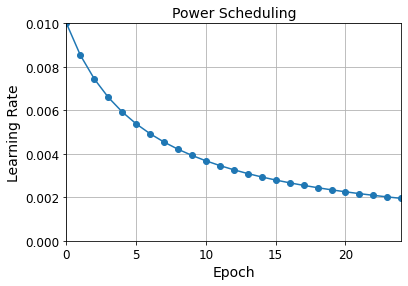

In [73]:
import math

learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = math.ceil(len(X_train) / batch_size)
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs, "o-")
plt.axis([0,n_epochs - 1,0 ,0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

- 지수 기반 스케쥴링

In [74]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1 **(epoch/20)

In [75]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch/s)
    return exponential_decay_fn
exponential_deay_fn = exponential_decay(lr0=0.01,s=20)

In [76]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [77]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                   validation_data=(X_valid_scaled,y_valid),
                   callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.8319 - accuracy: 0.7605 - val_loss: 1.0567 - val_accuracy: 0.7162 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7210 - accuracy: 0.7858 - val_loss: 0.6901 - val_accuracy: 0.7720 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5922 - accuracy: 0.8154 - val_loss: 1.0076 - val_accuracy: 0.6570 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5268 - accuracy: 0.8358 - val_loss: 0.6911 - val_accuracy: 0.8334 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4983 - accuracy: 0.8473 - val_loss: 0.4948 - val_accuracy: 0.8604 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4459 - accuracy: 0.8618 - val_loss: 0.5380 - val_accuracy: 0.8580 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 5s

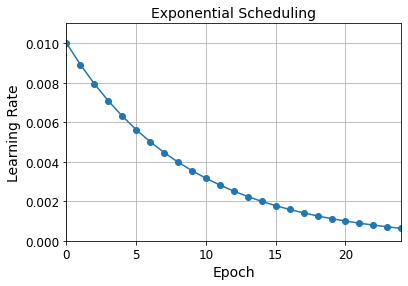

In [78]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

In [79]:
def exponential_decay_fn(epoch,lr):
    return lr * 0.1 **(1/20)

In [80]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # 노트: 에포크마다 `batch` 매개변수가 재설정됩니다
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / self.s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25

s = 20 * len(X_train) // 32 # 20 에포크 동안 스텝 횟수 (배치 크기 = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/25
1719/1719 [==============================] - 7s 4ms/step - loss: 0.7855 - accuracy: 0.7684 - val_loss: 0.8415 - val_accuracy: 0.7630 - lr: 0.0089
Epoch 2/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.6529 - accuracy: 0.8020 - val_loss: 0.5879 - val_accuracy: 0.8350 - lr: 0.0079
Epoch 3/25
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5723 - accuracy: 0.8241 - val_loss: 0.5818 - val_accuracy: 0.8068 - lr: 0.0071
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4901 - accuracy: 0.8456 - val_loss: 0.4912 - val_accuracy: 0.8462 - lr: 0.0063
Epoch 5/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4668 - accuracy: 0.8527 - val_loss: 0.5439 - val_accuracy: 0.8490 - lr: 0.0056
Epoch 6/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.4137 - accuracy: 0.8665 - val_loss: 0.4606 - val_accuracy: 0.8592 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 6s

In [81]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

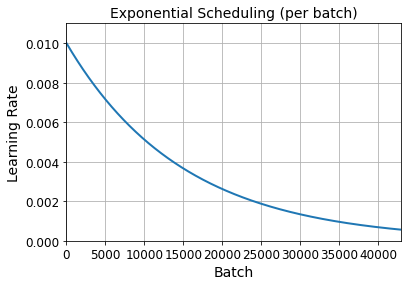

In [82]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

* 구간별 고정 스케쥴링

In [83]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [84]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [85]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.9121 - accuracy: 0.7428 - val_loss: 0.7881 - val_accuracy: 0.7152 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.9747 - accuracy: 0.7029 - val_loss: 0.8178 - val_accuracy: 0.7068 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0094 - accuracy: 0.6875 - val_loss: 1.5374 - val_accuracy: 0.5874 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0768 - accuracy: 0.6649 - val_loss: 0.9010 - val_accuracy: 0.6904 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 5s 3ms/step - loss: 1.0905 - accuracy: 0.6576 - val_loss: 1.1531 - val_accuracy: 0.5570 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7598 - accuracy: 0.7230 - val_loss: 0.7356 - val_accuracy: 0.7448 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 5s

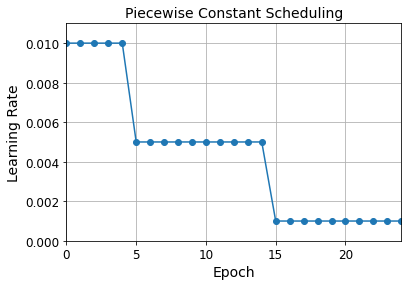

In [86]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

* 성능 기반 스케줄링

In [87]:
tf.random.set_seed(42)
np.random.seed(42)

In [89]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.5890 - accuracy: 0.8079 - val_loss: 0.4959 - val_accuracy: 0.8482 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4999 - accuracy: 0.8390 - val_loss: 0.5817 - val_accuracy: 0.8392 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5220 - accuracy: 0.8404 - val_loss: 0.4822 - val_accuracy: 0.8528 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5109 - accuracy: 0.8457 - val_loss: 0.4838 - val_accuracy: 0.8556 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 4s 3ms/step - loss: 0.5149 - accuracy: 0.8493 - val_loss: 0.5059 - val_accuracy: 0.8486 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4828 - accuracy: 0.8581 - val_loss: 0.5545 - val_accuracy: 0.8548 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 5s

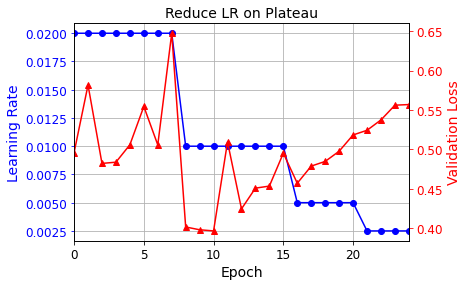

In [90]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

* tf.keras 스케줄링

In [91]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
optimizer = keras.optimizers.SGD(learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4894 - accuracy: 0.8274 - val_loss: 0.4092 - val_accuracy: 0.8604
Epoch 2/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3820 - accuracy: 0.8651 - val_loss: 0.3739 - val_accuracy: 0.8692
Epoch 3/25
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3488 - accuracy: 0.8766 - val_loss: 0.3733 - val_accuracy: 0.8686
Epoch 4/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3264 - accuracy: 0.8838 - val_loss: 0.3494 - val_accuracy: 0.8810
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3104 - accuracy: 0.8897 - val_loss: 0.3430 - val_accuracy: 0.8800
Epoch 6/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2958 - accuracy: 0.8951 - val_loss: 0.3416 - val_accuracy: 0.8812
Epoch 7/25
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2854 - accuracy: 0.8987 - val_loss: 0.3356 - val_accuracy:

* 1사이클 스케줄링

In [92]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = math.ceil(len(X) / batch_size) * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size,
                        callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [93]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

430/430 [==============================] - 2s 4ms/step - loss: 2722270531289088.0000 - accuracy: 0.3867


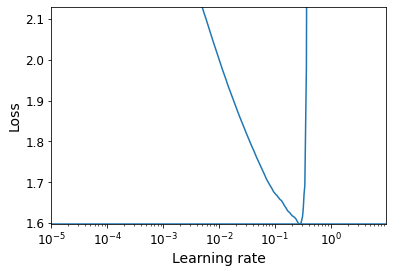

In [94]:
batch_size = 128
rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
plot_lr_vs_loss(rates, losses)

In [95]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [96]:
n_epochs = 25
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
430/430 [==============================] - 2s 4ms/step - loss: 0.6572 - accuracy: 0.7740 - val_loss: 0.4872 - val_accuracy: 0.8336
Epoch 2/25
430/430 [==============================] - 2s 3ms/step - loss: 0.4581 - accuracy: 0.8395 - val_loss: 0.4275 - val_accuracy: 0.8522
Epoch 3/25
430/430 [==============================] - 2s 4ms/step - loss: 0.4122 - accuracy: 0.8547 - val_loss: 0.4115 - val_accuracy: 0.8582
Epoch 4/25
430/430 [==============================] - 2s 4ms/step - loss: 0.3837 - accuracy: 0.8641 - val_loss: 0.3868 - val_accuracy: 0.8682
Epoch 5/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3639 - accuracy: 0.8718 - val_loss: 0.3766 - val_accuracy: 0.8688
Epoch 6/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3457 - accuracy: 0.8771 - val_loss: 0.3742 - val_accuracy: 0.8710
Epoch 7/25
430/430 [==============================] - 1s 3ms/step - loss: 0.3330 - accuracy: 0.8809 - val_loss: 0.3636 - val_accuracy: 0.8714
Epoch 

## 11.4 규제를 사용해 과대적합 피하기

### 11.4.1 $l_1$과 $l_2$의 규제

In [98]:
layer = keras.layers.Dense(100, activation="elu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01))

In [99]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [101]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                          activation="elu",
                          kernel_initializer="he_normal",
                          kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax",
                    kernel_initializer="glorot_uniform")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs=2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 6s 3ms/step - loss: 1.6699 - accuracy: 0.8116 - val_loss: 0.7200 - val_accuracy: 0.8324
Epoch 2/2
1719/1719 [==============================] - 5s 3ms/step - loss: 0.7182 - accuracy: 0.8276 - val_loss: 0.6826 - val_accuracy: 0.8376


### 11.4.2 드롭아웃
- 일반적으로 출력층을 제외한 맨 위의 층부터 세 번째 층까지 있는 뉴런에만 드롭아웃을 적용합니다.
- 드롭아웃은 훈련하는 동안에만 활성하되므로 훈련 손실과 검증 손실을 비교하면 오해를 일으키기 쉽습니다. 특히 비슷한 훈련 손실과 검증 손실을 얻었더라도 모델이 훈련 세트에 과대적합될 수 있습니다. 따라서 훈련이 끝난 후 드롭아웃을 빼고 훈련 손실을 평가해야 합니다.

In [102]:
tf.random.set_seed(42)
np.random.seed(42)

In [107]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300,activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs=20
history = model.fit(X_train_scaled, y_train, epochs = n_epochs,
                       validation_data=(X_valid_scaled,y_valid))

Epoch 1/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.6602 - accuracy: 0.7582 - val_loss: 0.6102 - val_accuracy: 0.8410
Epoch 2/20
1719/1719 [==============================] - 8s 4ms/step - loss: 0.5559 - accuracy: 0.7942 - val_loss: 0.5616 - val_accuracy: 0.8406
Epoch 3/20
1719/1719 [==============================] - 6s 4ms/step - loss: 0.5237 - accuracy: 0.8045 - val_loss: 0.5223 - val_accuracy: 0.8502
Epoch 4/20
1719/1719 [==============================] - 10s 6ms/step - loss: 0.5045 - accuracy: 0.8140 - val_loss: 0.4777 - val_accuracy: 0.8614
Epoch 5/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4944 - accuracy: 0.8151 - val_loss: 0.4419 - val_accuracy: 0.8580
Epoch 6/20
1719/1719 [==============================] - 7s 4ms/step - loss: 0.4823 - accuracy: 0.8222 - val_loss: 0.4709 - val_accuracy: 0.8602
Epoch 7/20
1719/1719 [==============================] - 9s 5ms/step - loss: 0.4716 - accuracy: 0.8260 - val_loss: 0.4627 - val_accuracy

In [109]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.4462 - accuracy: 0.8597


[0.44622138142585754, 0.8597000241279602]

In [110]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 4s 2ms/step - loss: 0.3291 - accuracy: 0.8823


[0.32914790511131287, 0.882309079170227]

In [111]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 10s 6ms/step - loss: 0.4218 - accuracy: 0.8431


### 11.4.3 몬테 카를로 드롭아웃

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

training=True 를 함으로써 Dropout이 활성화된다.

In [113]:
y_probas = np.stack([model(X_test_scaled, training=True)
                    for sample in range(100)])
y_proba = y_probas.mean(axis=0)

In [114]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], dtype=float32)

Dropout을 활성화하여 만든 예측과 비교

In [115]:
np.round(y_probas[:, :1], 2)

array([[[0.  , 0.  , 0.  , 0.  , 0.  , 0.48, 0.  , 0.01, 0.  , 0.51]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.14, 0.  , 0.8 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.02, 0.  , 0.95]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.21, 0.  , 0.76]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.16, 0.  , 0.83]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.12, 0.  , 0.63, 0.  , 0.25]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.03, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.82, 0.  , 0.08, 0.  , 0.1 ]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.07, 0.  , 0.4 , 0.  , 0.54]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.02, 0.  , 0.97]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.51, 0.  , 0.22, 0.  , 0.27]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.11, 0.  , 0.11, 0.  , 0.78]],

       [[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0

MC 드롭아웃의 예측

In [116]:
np.round(y_proba[:1], 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.17, 0.  , 0.21, 0.  , 0.63]],
      dtype=float32)

In [118]:
y_std = y_probas.std(axis=0)
np.round(y_std[:1],2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.21, 0.  , 0.2 , 0.  , 0.28]],
      dtype=float32)

In [119]:
y_pred = np.argmax(y_proba, axis=1)

In [120]:
accuracy = np.sum(y_pred == y_test) / len(y_test)
accuracy

0.869

In [121]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [122]:
class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [123]:
tf.random.set_seed(42)
np.random.seed(42)

In [124]:
mc_model = keras.models.Sequential([
    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
    for layer in model.layers
])

In [125]:
mc_model.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 784)               0         
                                                                 
 mc_alpha_dropout (MCAlphaDr  (None, 784)              0         
 opout)                                                          
                                                                 
 dense_165 (Dense)           (None, 300)               235500    
                                                                 
 mc_alpha_dropout_1 (MCAlpha  (None, 300)              0         
 Dropout)                                                        
                                                                 
 dense_166 (Dense)           (None, 100)               30100     
                                                                 
 mc_alpha_dropout_2 (MCAlpha  (None, 100)            

In [126]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [127]:
mc_model.set_weights(model.get_weights())

MC 드롭아웃은 드롭아웃 모델의 성능을 높여주고 더 정확한 불확실성 추정을 제공

In [128]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.19, 0.  , 0.2 , 0.  , 0.61]],
      dtype=float32)

### 11.4.4 맥스-노름 규제

In [129]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                          kernel_constraint = keras.constraints.max_norm(1.))

In [133]:
MaxNormDense = partial(keras.layers.Dense,
                      activation="selu", kernel_initializer="lecun_normal",
                      kernel_constraint=keras.constraints.max_norm(1.))
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28,28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs=2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                   validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 7s 3ms/step - loss: 0.4748 - accuracy: 0.8325 - val_loss: 0.3759 - val_accuracy: 0.8618
Epoch 2/2
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3526 - accuracy: 0.8711 - val_loss: 0.3885 - val_accuracy: 0.8630
